In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [1]:
ent_types = {
    "corporation": 194851,
    "conference": 15879,
    "location": 259964,
    "person": 544760,
    "technical term": 197978,
    "work": 133123

}

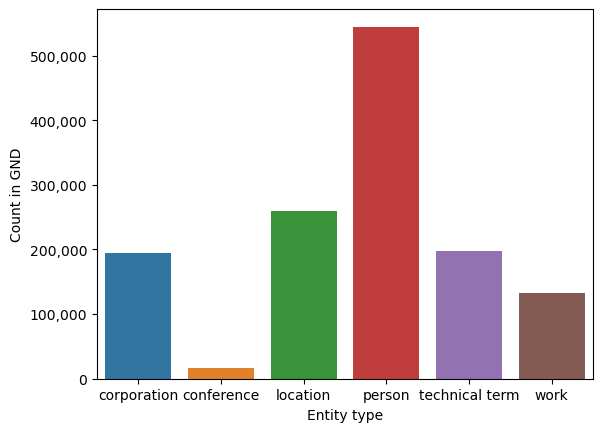

In [14]:
ax = sns.barplot(
    x = list(ent_types.keys()),
    y = list(ent_types.values())
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set(xlabel='Entity type', ylabel='Count in GND')
plt.show()